In [ ]:
 ! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
 ! cp /content/drive/MyDrive/Colab_Notebooks/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download sylviahamidah/cattle-tongue-dataset

 95% 91.0M/96.0M [00:07<00:00, 22.9MB/s]
100% 96.0M/96.0M [00:07<00:00, 13.7MB/s]


In [ ]:
! unzip /content/cattle-tongue-dataset.zip


Archive:  /content/cattle-tongue-dataset.zip
  inflating: tongue_dataset/fmd/augmented_fmdf_0.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_1.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_10.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_100.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_101.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_102.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_103.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_104.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_105.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_106.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_107.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_108.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_109.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_11.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_110.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_111.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_11

In [ ]:
#Import the libraries
import zipfile
import os
import shutil
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

#zip_ref = zipfile.ZipFile('/content/drive/MyDrive/NETKIT BISA/datasets/dataset_feet.zip', 'r') #Opens the zip file in read mode
#zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
#zip_ref.close()

In [ ]:
# directories
dir_list = ['/tongue_dataset/fmd', '/tongue_dataset/healthy']

base_dir = '/tmp/dataset'
train_dir = '/tmp/dataset/train/'
test_dir = '/tmp/dataset/test/'

train_aug = '/tmp/augmented/train/'
test_aug = '/tmp/augmented/test/'

classes = ['fmd_tongue', 'healthy_tongue']

In [ ]:
# Create new folders
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

for i in classes:
  os.mkdir(os.path.join(train_dir,i))
for k in classes:
  os.mkdir(os.path.join(test_dir,k))


In [ ]:
# FUNCTION: split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  # Shuffle list
  shuffled_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))

  # Find total number of files in training dir
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING

  for item in shuffled_source:
    item_source = os.path.join(SOURCE, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING
    if i == training_number:
      target = TESTING



In [ ]:
# Test your split_data function

# Define paths
FMDF_SOURCE_DIR = "/content/tongue_dataset/fmd"
HEALTHYF_SOURCE_DIR = "/content/tongue_dataset/healthy"

TRAINING_DIR = "/tmp/dataset/train"
TESTING_DIR = "/tmp/dataset/test"

TRAINING_FMDF_DIR = "/tmp/dataset/train/fmd_tongue"
TESTING_FMDF_DIR = "/tmp/dataset/test/fmd_tongue"

TRAINING_HEALTHYF_DIR = "/tmp/dataset/train/healthy_tongue"
TESTING_HEALTHYF_DIR = "/tmp/dataset/test/healthy_tongue"


# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_HEALTHYF_DIR)) > 0:
  for file in os.scandir(TRAINING_HEALTHYF_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FMDF_DIR)) > 0:
  for file in os.scandir(TRAINING_FMDF_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_HEALTHYF_DIR)) > 0:
  for file in os.scandir(TESTING_HEALTHYF_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FMDF_DIR)) > 0:
  for file in os.scandir(TESTING_FMDF_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(FMDF_SOURCE_DIR, TRAINING_FMDF_DIR, TESTING_FMDF_DIR, split_size)
split_data(HEALTHYF_SOURCE_DIR, TRAINING_HEALTHYF_DIR, TESTING_HEALTHYF_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_HEALTHYF_DIR))} images of healthy feet for training")
print(f"There are {len(os.listdir(TRAINING_FMDF_DIR))} images of fmd feet for training")
print(f"There are {len(os.listdir(TESTING_HEALTHYF_DIR))} images of healthy feet for testing")
print(f"There are {len(os.listdir(TESTING_FMDF_DIR))} images of fmd feet for testing")



There are 168 images of healthy feet for training
There are 173 images of fmd feet for training
There are 42 images of healthy feet for testing
There are 44 images of fmd feet for testing


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 60,
                                     width_shift_range = 0.4,
                                     height_shift_range = 0.4,
                                     shear_range = 0.4,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 20,
                                                      class_mode = 'binary',
                                                      target_size = (150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 10,
                                                                class_mode = 'binary',
                                                                target_size = (150, 150))
  ### END CODE HERE
  return train_generator, validation_generator


In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)


Found 341 images belonging to 2 classes.
Found 86 images belonging to 2 classes.


In [ ]:
class myCallback(keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        
        def on_epoch_end(self, epoch, logs=None):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:                 
                print("\nReached 99% accuracy so cancelling training!")
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [ ]:
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  # Instantiate the callback class
  #callbacks = myCallback()

  model = tf.keras.models.Sequential([
      # Note the input shape is the desired size of the image 150x150 with 3 bytes color
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2), 
     
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
   
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
    
    
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(), 
      # 512 neuron hidden layer
      tf.keras.layers.Dense(256, activation='relu'), 
      tf.keras.layers.Dense(512, activation='relu'), 
      tf.keras.layers.Dropout(0.5),
      # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  from tensorflow.keras.optimizers import Adam

  model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy']
                )
     
  ### END CODE HERE

  return model


In [ ]:
initial_learning_rate = 0.01
epochs = 200
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [ ]:
from keras.api._v2.keras import callbacks
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=150,
                    validation_data=validation_generator
                    )


Epoch 1/150
18/18 [==============================] - 12s 506ms/step - loss: 0.6889 - accuracy: 0.5015 - val_loss: 0.6781 - val_accuracy: 0.5116
Epoch 2/150
18/18 [==============================] - 9s 546ms/step - loss: 0.6802 - accuracy: 0.5103 - val_loss: 0.6626 - val_accuracy: 0.5116
Epoch 3/150
18/18 [==============================] - 9s 516ms/step - loss: 0.6724 - accuracy: 0.6070 - val_loss: 0.6421 - val_accuracy: 0.5581
Epoch 4/150
18/18 [==============================] - 9s 521ms/step - loss: 0.6518 - accuracy: 0.5718 - val_loss: 0.5814 - val_accuracy: 0.9070
Epoch 5/150
18/18 [==============================] - 9s 539ms/step - loss: 0.6021 - accuracy: 0.7683 - val_loss: 0.5009 - val_accuracy: 0.9070
Epoch 6/150
18/18 [==============================] - 9s 515ms/step - loss: 0.5468 - accuracy: 0.8035 - val_loss: 0.4212 - val_accuracy: 0.8488
Epoch 7/150
18/18 [==============================] - 9s 490ms/step - loss: 0.4979 - accuracy: 0.7859 - val_loss: 0.3489 - val_accuracy: 0.860

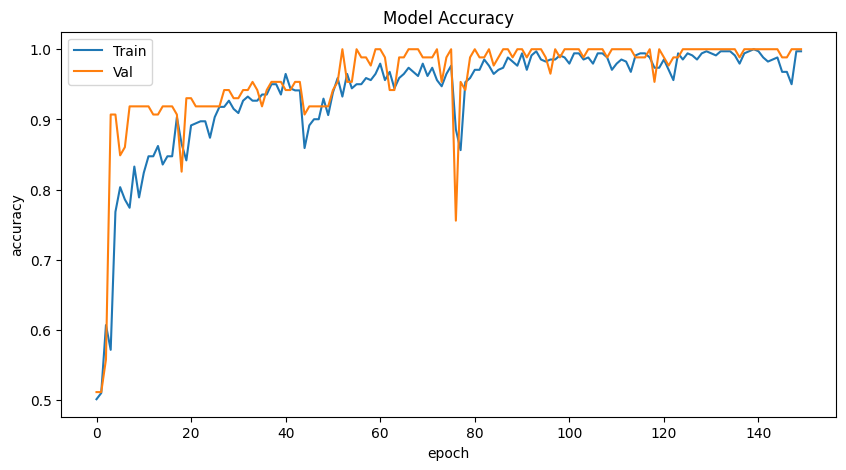

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

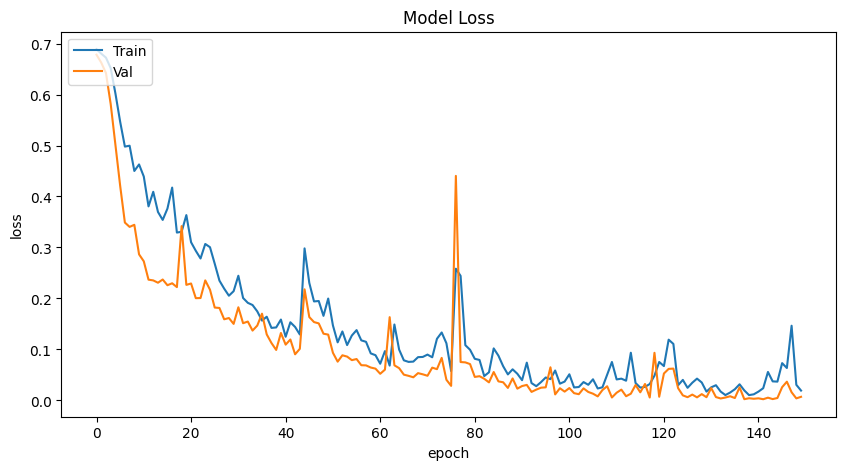

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()